In [ ]:
# make_second_reward_dataset.py
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib

CSV_FOLDERS = [
    Path(r"C:/Users/Developer/TCLab/csv/data_back3"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back4"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back5"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back6"),
]
DT          = 5.0          # sample interval [s]
N_STEP      = 5            #   <-- ✨ n-step future reward
SAVE_NPZ    = Path(r"C:/Users/Developer/TCLab/Data/future.npz")
SAVE_SCALER = Path(r"C:/Users/Developer/TCLab/Data/future.pkl")

obs_buf, act_buf, next_buf, rew_buf, done_buf = [], [], [], [], []

for folder in CSV_FOLDERS:
    for csv_path in sorted(folder.glob("mpc_episode_*_data.csv")):
        df = pd.read_csv(csv_path).reset_index(drop=True)

        episode_len = len(df)
        for i in range(episode_len):
            j = i + N_STEP          # future index

            # 2-A. (s_t, a_t)
            s_t =  [df.at[i, "T1"],   df.at[i, "T2"],
                    df.at[i, "TSP1"], df.at[i, "TSP2"]]
            a_t =  [df.at[i, "Q1"],   df.at[i, "Q2"]]

            # 2-B. s_{t+1}  (즉시 다음 상태 – IQL 등은 1-step next 가 필요)
            if i < episode_len - 1:
                s_tp1 = [df.at[i+1, "T1"],   df.at[i+1, "T2"],
                         df.at[i+1, "TSP1"], df.at[i+1, "TSP2"]]
            else:                      # 마지막 샘플이면 자기 자신
                s_tp1 = s_t

            # 2-C. n-step future reward
            if j < episode_len:
                T_future1, T_future2 = df.at[j, "T1"], df.at[j, "T2"]
                TSP_now1, TSP_now2   = df.at[i, "TSP1"], df.at[i, "TSP2"]
            else: 
                continue

            err1 = TSP_now1 - T_future1
            err2 = TSP_now2 - T_future2
            r_t  = -np.sqrt(err1**2 + err2**2)
            done = (i == episode_len - 1)

            # 2-D. 버퍼에 push
            obs_buf.append(s_t)
            act_buf.append(a_t)
            next_buf.append(s_tp1)
            rew_buf.append(r_t)
            done_buf.append(done)

rew_arr   = np.array(rew_buf, dtype=np.float32).reshape(-1,1)
scaler    = StandardScaler().fit(rew_arr)
rew_norm  = scaler.transform(rew_arr).flatten()

dataset = {
    "observations"     : np.array(obs_buf,  dtype=np.float32),
    "actions"          : np.array(act_buf,  dtype=np.float32),
    "next_observations": np.array(next_buf, dtype=np.float32),
    "rewards"          : rew_norm.astype(np.float32),
    "terminals"        : np.array(done_buf, dtype=bool),
}
SAVE_NPZ.parent.mkdir(parents=True, exist_ok=True)
np.savez(SAVE_NPZ, **dataset)
joblib.dump(scaler, SAVE_SCALER)

print(f"\n✅  NPZ saved  → {SAVE_NPZ}")
print(f"✅  Scaler saved → {SAVE_SCALER}")
print(f"Total transitions : {len(obs_buf):,}")
print(f"Reward mean/std   : {rew_norm.mean():.3f} / {rew_norm.std():.3f}")
print(f"Obs dim           : {dataset['observations'].shape[1]}")



✅  NPZ saved  → C:\Users\Developer\TCLab\Data\future.npz
✅  Scaler saved → C:\Users\Developer\TCLab\Data\future.pkl
Total transitions : 50,668
Reward mean/std   : -0.000 / 1.000
Obs dim           : 4


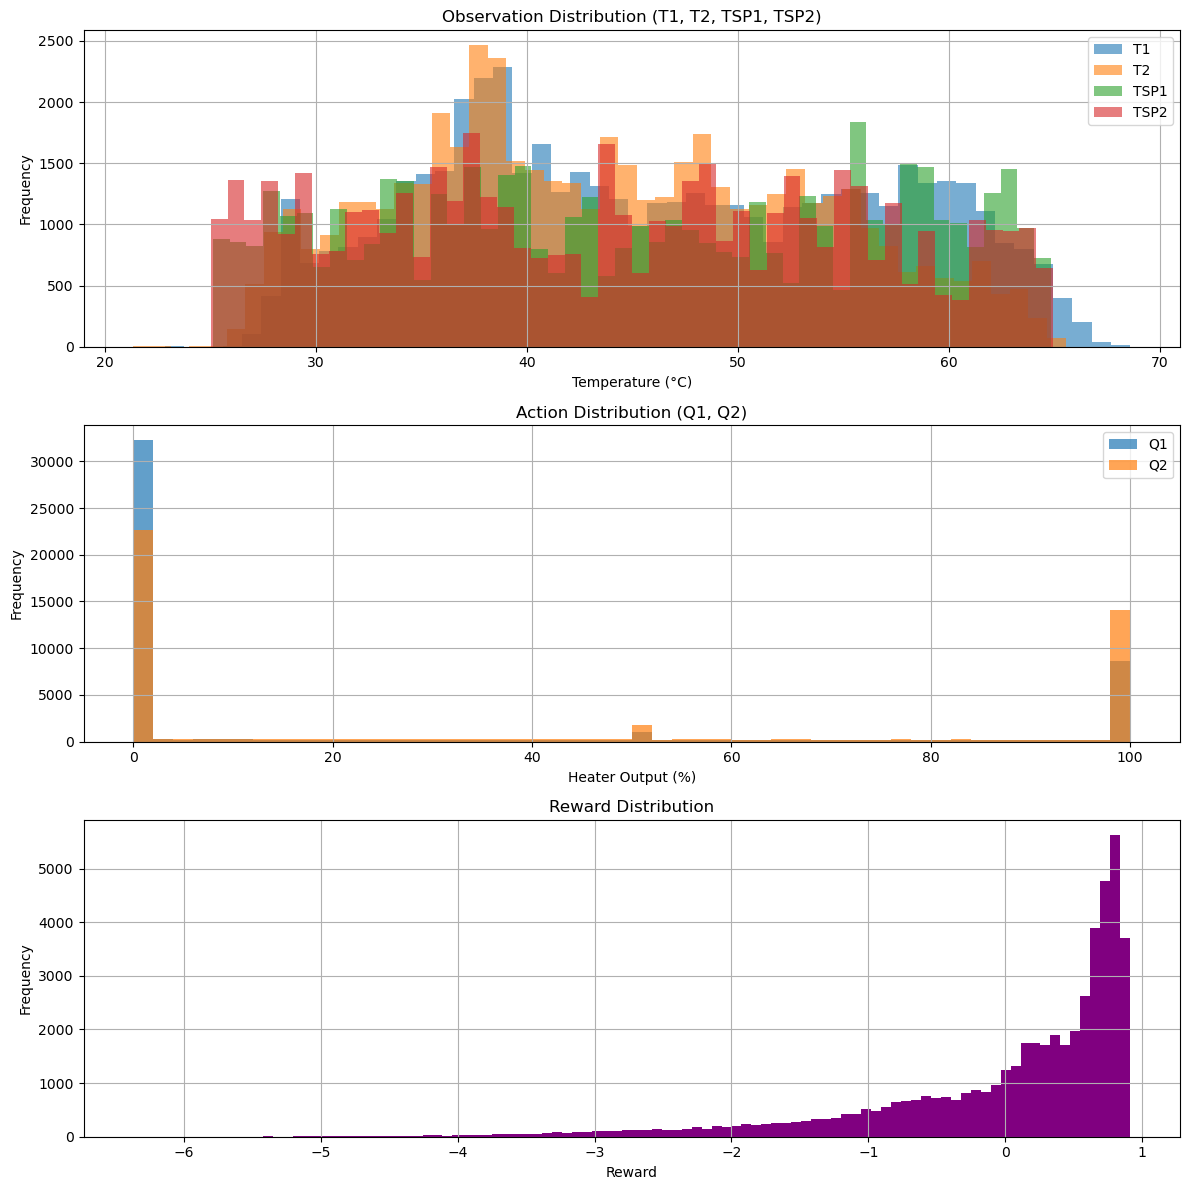

Reward mean: -3.6138286e-09
Reward std: 1.0


In [6]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# Reload dataset
data = np.load("C:/Users/Developer/TCLab/Data/MPC/future.npz")
# C:\\Users\\Developer\\TCLab\\Data\\mpc_dataset.npz
# Extract components
observations = data["observations"]
actions = data["actions"]
rewards = data["rewards"]

# Plot settings
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# 1. Observations (T1, T2, TSP1, TSP2)
axs[0].hist(observations[:, 0], bins=50, alpha=0.6, label="T1")
axs[0].hist(observations[:, 1], bins=50, alpha=0.6, label="T2")
axs[0].hist(observations[:, 2], bins=50, alpha=0.6, label="TSP1")
axs[0].hist(observations[:, 3], bins=50, alpha=0.6, label="TSP2")
axs[0].set_title("Observation Distribution (T1, T2, TSP1, TSP2)")
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

# 2. Actions (Q1, Q2)
axs[1].hist(actions[:, 0], bins=50, alpha=0.7, label="Q1")
axs[1].hist(actions[:, 1], bins=50, alpha=0.7, label="Q2")
axs[1].set_title("Action Distribution (Q1, Q2)")
axs[1].set_xlabel("Heater Output (%)")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

# 3. Reward distribution
axs[2].hist(rewards, bins=100, color='purple')
axs[2].set_title("Reward Distribution")
axs[2].set_xlabel("Reward")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)

plt.tight_layout()
plt.show()
print("Reward mean:", np.mean(rewards))
print("Reward std:", np.std(rewards))


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load file after user upload
file_path = "/mnt/data/future.npz"
data = np.load("C:/Users/Developer/TCLab/Data/MPC/future.npz")

# Extract observations
obs = data["observations"]

# Compute deltas
delta1 = obs[:, 2] - obs[:, 0]  # TSP1 - T1
delta2 = obs[:, 3] - obs[:, 1]  # TSP2 - T2

# Sweep over multiple thresholds
thresholds = [0.5, 1.0, 1.5, 2.0, 3.0]
results = []

for thr in thresholds:
    cnt1 = np.sum(np.abs(delta1) > thr)
    cnt2 = np.sum(np.abs(delta2) > thr)
    total = cnt1 + cnt2
    results.append((thr, cnt1, cnt2, total))

import pandas as pd
import ace_tools as tools

df = pd.DataFrame(results, columns=["Threshold", "Delta1 > thr", "Delta2 > thr", "Total > thr"])
tools.display_dataframe_to_user(name="Error Count by Threshold", dataframe=df)


ModuleNotFoundError: No module named 'ace_tools'

전체 샘플 수: 101336
▶|TSP1 - T1| > 1.0 인 개수: 33596
▶|TSP2 - T2| > 1.0 인 개수: 26545
총 오차(>1.0도) 개수: 60141
전체 중 1.0 이상 오차 비율: 59.35%


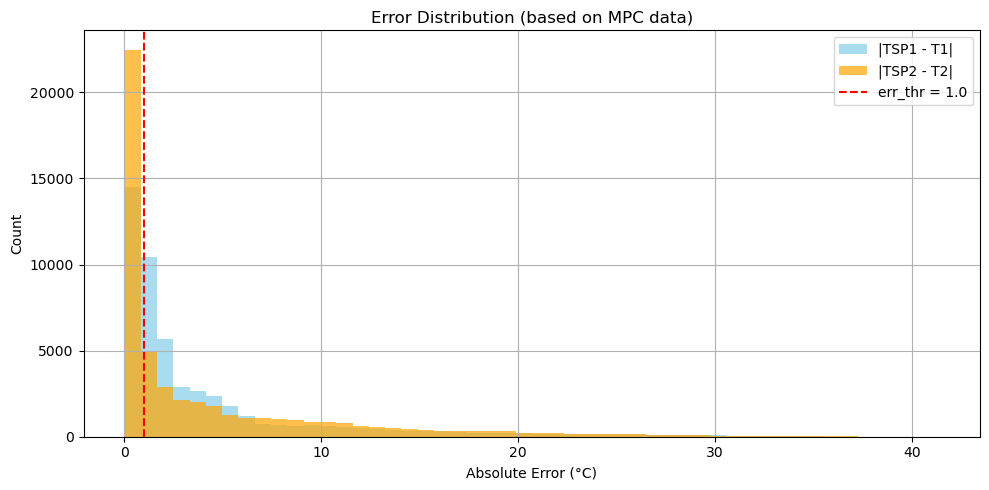

In [17]:
# 기존 코드 (생략 없이 유지)
import numpy as np
import matplotlib.pyplot as plt

data = np.load("C:/Users/Developer/TCLab/Data/MPC/future.npz")
obs = data["observations"]  # shape: (N, 4)

T1   = obs[:, 0]
T2   = obs[:, 1]
TSP1 = obs[:, 2]
TSP2 = obs[:, 3]

# 절대 오차 계산
err1 = np.abs(TSP1 - T1)
err2 = np.abs(TSP2 - T2)

# 🎯 오차 임계값 설정
err_thr = 1.0

# 전체 개수
total_samples = len(err1) + len(err2)

# ✅ 1도 이상 오차 개수 세기
cnt_err1 = np.sum(err1 > err_thr)
cnt_err2 = np.sum(err2 > err_thr)
total_cnt = cnt_err1 + cnt_err2

# ✅ 비율 계산
percent = total_cnt / total_samples * 100

# 출력
print(f"전체 샘플 수: {total_samples}")
print(f"▶|TSP1 - T1| > {err_thr} 인 개수: {cnt_err1}")
print(f"▶|TSP2 - T2| > {err_thr} 인 개수: {cnt_err2}")
print(f"총 오차(>1.0도) 개수: {total_cnt}")
print(f"전체 중 {err_thr} 이상 오차 비율: {percent:.2f}%")

# 📊 히스토그램 시각화
plt.figure(figsize=(10, 5))
plt.hist(err1, bins=50, alpha=0.7, label="|TSP1 - T1|", color='skyblue')
plt.hist(err2, bins=50, alpha=0.7, label="|TSP2 - T2|", color='orange')
plt.axvline(err_thr, color='red', linestyle='--', label=f"err_thr = {err_thr}")

plt.title("Error Distribution (based on MPC data)")
plt.xlabel("Absolute Error (°C)")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
